In [1]:
# load two similar files

In [1]:
import sys
sys.path.append('/home/simon/git/molnet/code')

In [42]:
data_dir = '/home/simon/Dropbox/BioResearch/Meta_clustering/MS2LDA/multifile_ms2lda_manuscript/Supporting_Files/data/urines/'
f1 = data_dir + 'Urine_StrokeDrugs_02_T10_POS.mzML'
f2 = data_dir + 'Urine_StrokeDrugs_97_T10_POS.mzML'

In [43]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
from mnet import *
f1_loader = MNetLoadMZML(f1)
f1_ms1,f1_spectra = f1_loader.load_spectra()
f2_loader = MNetLoadMZML(f2)
f2_ms1,f2_spectra = f2_loader.load_spectra()



Loading spectra from /home/simon/Dropbox/BioResearch/Meta_clustering/MS2LDA/multifile_ms2lda_manuscript/Supporting_Files/data/urines/Urine_StrokeDrugs_02_T10_POS.mzML
Loaded 8519 spectra
After duplicate filtering, 285 spectra remain
Loading spectra from /home/simon/Dropbox/BioResearch/Meta_clustering/MS2LDA/multifile_ms2lda_manuscript/Supporting_Files/data/urines/Urine_StrokeDrugs_97_T10_POS.mzML
Loaded 8894 spectra
After duplicate filtering, 306 spectra remain


In [45]:
from scoring_functions import fast_cosine

In [53]:
mz_tol = 0.1 # precursors have to be within plus and minus this
rt_tol = 15 # MS2 rt has to be within plus and minus this (see below)
matches = [] # This will hold tuples of pairs of spectra, one from each file that match.
# If there is more than one match, the one with the highest cosine will be kept
missing = [] # This will hold spectra from file 1 that don't have a match in file 2
min_score = 0.8 # Minimum cosine score to constitute a match
for s in f1_spectra:
    best_match = None
    best_score = 0
    for s2 in f2_spectra:
        if abs(s.precursor_mz - s2.precursor_mz) <= mz_tol and abs(s.rt - s2.rt) <= rt_tol:
            sc,_ = fast_cosine_shift(s,s2,0.2,1)
            if sc > min_score and sc > best_score:
                best_match = s2
    if best_match:
        matches.append((s,best_match))
    else:
        missing.append(s)
            

Plot the retention times of the matching spectra across the two files

122  spectra can be matched


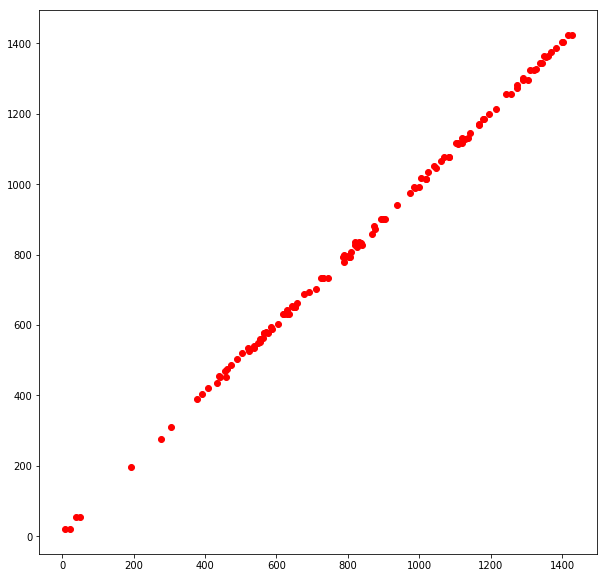

In [54]:
import numpy as np
times = np.array([(s[0].rt,s[1].rt) for s in matches])
import pylab as plt
%matplotlib inline
plt.figure(figsize=(10,10))
plt.plot(times[:,0],times[:,1],'ro')
print len(times)," spectra can be matched"

Plot the time difference versus time in file 1, including a Gaussian Process trend line

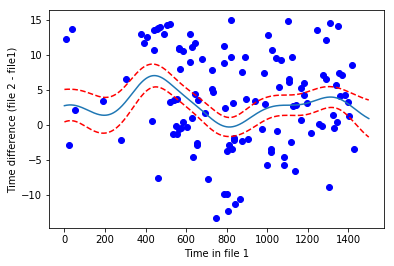

In [89]:
plt.plot(times[:,0],times[:,1]-times[:,0],'bo')
plt.xlabel('Time in file 1')
plt.ylabel('Time difference (file 2 - file1)')
testx = np.linspace(0,1500,1000)
mu,ss = gp_regression(times[:,0],times[:,1]-times[:,0],testx,gamma = 0.00010,ss=5)
plt.plot(testx,mu)
plt.plot(testx,mu+3*np.sqrt(ss),'r--')
plt.plot(testx,mu-3*np.sqrt(ss),'r--')


In [83]:
def rbf(x1,x2,alpha = 1,gamma = 1):
    return alpha*np.exp(-0.5*gamma*(x1-x2)**2)
def gp_regression(train_x,train_y,test_x,alpha = 1,gamma = 1,ss=1):
    N = len(train_x)
    testN = len(test_x)
    K = np.zeros((N,N))
    testK = np.zeros((testN,N))
    for n in range(N):
        for n2 in range(N):
            K[n,n2] = rbf(train_x[n],train_x[n2],alpha = alpha,gamma = gamma)
        for n2 in range(testN):
            testK[n2,n] = rbf(test_x[n2],train_x[n],alpha = alpha,gamma = gamma)
    
    K += ss*np.eye(N)
    Ki = np.linalg.inv(K)
    pred_mu = np.dot(np.dot(testK,Ki),train_y)
    pred_ss = alpha - np.diag(np.dot(np.dot(testK,Ki),testK.T))
    return pred_mu,pred_ss

Looks mucky! See thoughts below as to why

Look at some missing examples, and see if there really was a match that we missed...

- find cosines between the spectrum and all spectra in file 2 and store those higher than the minimum value

In [34]:
m = missing[2]
o = []
for s in f2_spectra:
    sc,_ = fast_cosine_shift(m,s,0.2,1)
    o.append((s.precursor_mz,s.rt,sc))
o = filter(lambda x: x[2] >= min_score,o)

Plot a small region around the missing one (blue) and see if there were any real ones (red)

mz = 114.1 rt = 39.5985


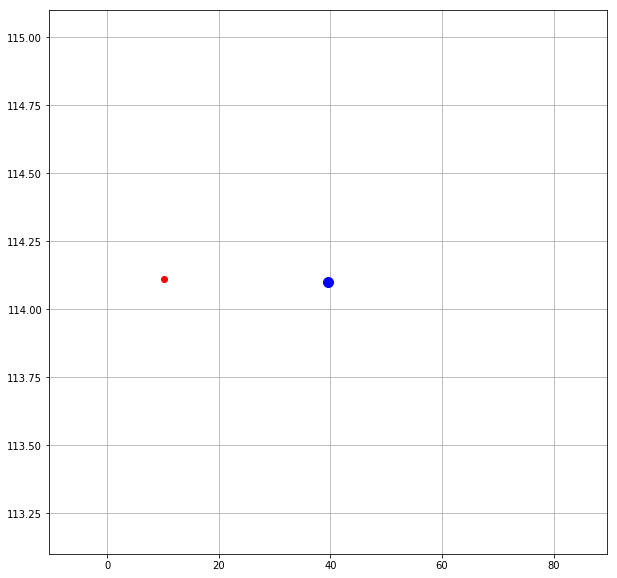

In [35]:
print "mz =",m.precursor_mz,"rt =",m.rt
plt.figure(figsize=(10,10))
plt.plot(m.rt,m.precursor_mz,'bo',markersize=10)
for a in o:
    plt.plot(a[1],a[0],'o',color=[a[2],0,0])
plt.ylim([m.precursor_mz-1,m.precursor_mz+1])
plt.xlim([m.rt - 50,m.rt + 50])
plt.grid()

Thoughts:

- Would be much better to use (e.g.) mzMine output here as I don't think it's ideal to be using the RT of the MS2 spectrum. Whilst RT of MS1 peaks will move due to drift, RT of MS2 spectra will also move due to when in the peak the MS2 spectra was collected. This can lead to large unpredictable deviations.
- It would also overcome the issue of deciding which RT to use for MS2 when the same peak is fragmented more than once. At the moment, my duplicate filter just uses the RT of the MS2 scan that has the maximum total intensity (I think).
- Those issues aside, it looks like there is definitely potential here.

Next steps:

- Get mzMine output instead of this pre-processing. How does mzMine handle multiple MS2 events for a single MS1 peak. Be good if they had solved that problem
- Do some regresion (GP feels good for this) to map time in one space to time in the other...